In [8]:
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
from tqdm.notebook import tqdm, trange
sns.set_theme(style="ticks")

df = sns.load_dataset("penguins")
# sns.pairplot(df, hue="species")

In [9]:
df = df.dropna()

In [10]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_df = df.select_dtypes(include=numerics)

In [11]:
num_df.to_json

<bound method NDFrame.to_json of      bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0              39.1           18.7              181.0       3750.0
1              39.5           17.4              186.0       3800.0
2              40.3           18.0              195.0       3250.0
4              36.7           19.3              193.0       3450.0
5              39.3           20.6              190.0       3650.0
..              ...            ...                ...          ...
338            47.2           13.7              214.0       4925.0
340            46.8           14.3              215.0       4850.0
341            50.4           15.7              222.0       5750.0
342            45.2           14.8              212.0       5200.0
343            49.9           16.1              213.0       5400.0

[333 rows x 4 columns]>

In [12]:
scatter = df[['bill_length_mm', 'bill_depth_mm']]

C:\Users\anjul\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


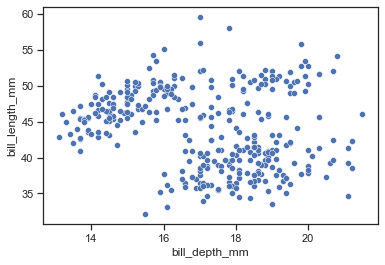

In [13]:
sns.scatterplot(scatter['bill_depth_mm'], scatter['bill_length_mm'])

In [14]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

def get_best_cluster_labels(cur_pts):
    data = scatter.iloc[cur_pts]
    scores_2d = -1
    scores_x = -1
    scores_y = -1
    labels_2d, labels_x, labels_y = [0], [0], [0]
    best_2d, best_x, best_y = 0,0,0
    for n_clusters in [2,3,4,5,6]:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        try:
            cur_labels_2d = clusterer.fit_predict(data)
            cur_labels_x = clusterer.fit_predict(np.array(data['bill_depth_mm']).reshape(-1,1))
            cur_labels_y = clusterer.fit_predict(np.array(data['bill_length_mm']).reshape(-1,1))
            cur_score_2d = silhouette_score(data, cur_labels_2d)
            cur_score_x = silhouette_score(np.array(data['bill_depth_mm']).reshape(-1,1), 
                                           cur_labels_x)
            cur_score_y = silhouette_score(np.array(data['bill_length_mm']).reshape(-1,1), 
                                       cur_labels_y)
        except ValueError:
            cur_score_2d = -1
            cur_score_x = -1
            cur_score_y = -1

        if cur_score_2d > scores_2d:
            scores_2d = cur_score_2d
            labels_2d = cur_labels_2d
            best_2d = n_clusters
        if cur_score_x > scores_x:
            scores_x = cur_score_x
            labels_x = cur_labels_x
            best_x = n_clusters
        if cur_score_y > scores_y:
            scores_y = cur_score_y
            labels_y = cur_labels_y
            best_y = n_clusters
    return labels_2d, labels_x, labels_y, best_2d, best_x, best_y

Important points
- All the properties are independent of each other
- Each point can have multiple properties

Algorithm initial steps
- Make the clusters very small for effective functioning of the detectors

PCP marginal clusters

- All the points are in same clusters (neighborhood)
    - Set Difference is zero
- Density of a cluster changes in the other axis (density change)
- Points split up into multiple clusters (Split up)
    - Default every point is marked split up
- Small cluster in one axis become many different clusters on the other axis with higher density (Fan)
- Evenly spread in both axis (Clutter)

PCP scatterplot clusters
- Outlier detection
- correlation
- variance
- skewness
- clear grouping

In [15]:
def neighborhood(cl_1, cl_2):
    if set(cl_1) - set(cl_2) == set():
        return True
    return False

In [16]:
x_pts = np.linspace(scatter.bill_length_mm.min(), scatter.bill_length_mm.max(), 5)
y_pts = np.linspace(scatter.bill_depth_mm.min(), scatter.bill_depth_mm.max(), 5)

In [17]:
x_range = scatter.bill_length_mm.max() - scatter.bill_length_mm.min()
y_range = scatter.bill_depth_mm.max() - scatter.bill_depth_mm.min()

In [18]:
x_windows = np.linspace(x_range/10, x_range, 6)
y_windows = np.linspace(y_range/10, y_range, 6)

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
scatter['labels_2d'] = 0
scatter['labels_x'] = 0
scatter['labels_y'] = 0
scatter['correlation'] = 0
scatter['variance'] = 0
scatter['skewness'] = 0
scatter['neigh'] = False
scatter['split_up'] = False
scatter['fan'] = False

In [21]:
import sys
results = {}
for x in tqdm(range(len(x_pts))):
    for y in range(len(y_pts)):
        for wx in x_windows:
            for wy in y_windows:
                # Choosing the points in that grid
                cur_pts = np.where((scatter.bill_length_mm >= x_pts[x]) & 
                            (scatter.bill_length_mm <= x_pts[x]+wx) &
                            (scatter.bill_depth_mm >= y_pts[y]) &
                            (scatter.bill_depth_mm <= y_pts[y]+wy)
                           )
                
                if len(cur_pts[0]) > 0:
                    # For current grid, get the best labels for 2d and marginal clusters
                    labels_2d, labels_x, labels_y, best_2d, best_x, best_y = get_best_cluster_labels(cur_pts)
                    correlation, variance, skewness = 0,0,0
                    neigh, split_up, fan = False, False, False
                    # Assign 2d and marginal ids to each point in the current sliding window
                    for i, ids in enumerate(cur_pts):
                        scatter.labels_2d.iloc[ids] = labels_2d[i]
                        scatter.labels_x.iloc[ids] = labels_x[i]
                        scatter.labels_y.iloc[ids] = labels_y[i]
#                     data_sub = scatter.loc[cur_pts]
                    data = scatter.iloc[cur_pts]
                    matrix = data[['bill_length_mm', 'bill_depth_mm']]
#                     print(data)
#                     sys.exit()
                    # Calculate 2d props for points in current window
#                     for cl_2d in range(best_2d):
#                         pts_2d = data[data['labels_2d'] == cl_2d][['bill_length_mm', 'bill_depth_mm']]
                    correlation = matrix.corr()
                    correlation = correlation['bill_length_mm']['bill_depth_mm']
                    variance = np.cov(matrix.T)[0,1]
                    skewness = scipy.stats.skew(matrix)
                    results[x,y,wx,wy,'corr'] = correlation
                    results[x,y,wx,wy,'var'] = variance
                    results[x,y,wx,wy,'skew'] = skewness
#                         for ids in pts_2d.index:
#                             scatter.correlation.loc[ids] = correlation
#                             scatter.skewness.loc[ids] = skewness[0]
#                             scatter.variance.loc[ids] = variance

                    # For every x and y cluster, calculate marginal props
                    for cl_x in range(best_x):
                        cur_clx_data = data[data['labels_x'] == cl_x][['bill_length_mm']]
                        for cl_y in range(best_y):
                            cur_cly_data = data[data['labels_y'] == cl_y][['bill_depth_mm']]
                            #  print(list(cur_clx_data.index))
                            neigh = neighborhood(cur_clx_data.index, cur_cly_data.index)
                            # Count the number of unique clusters in y coming from x      
                        split_up_count = np.unique(data[['labels_y']].loc[cur_clx_data.index])
                        split_up = False
                        if split_up_count > 1:
                            split_up = True
                        fan  = (len(cur_clx_data) == len(np.unique(data[['labels_y']].loc[cur_clx_data.index])))
                        results[x,y,wx,wy,'neigh'] = neigh
                        results[x,y,wx,wy,'split'] = split_up
                        results[x,y,wx,wy,'fan'] = fan
#                         for ids in cur_clx_data.index:
#                             scatter.neigh.loc[ids] = neigh
#                             scatter.split_up.loc[ids] = split_up
#         




scatter.fan.loc[ids] = fan
                    

KeyError: "None of [Int64Index([246], dtype='int64')] are in the [index]"

In [69]:
scatter.correlation[scatter.correlation > 0.25] = True
scatter.correlation[scatter.correlation < -0.25] = True

In [70]:
scatter.correlation[scatter.correlation != True] = False

In [71]:
scatter.variance[scatter.variance > scatter.variance.mean()] = True
scatter.variance[scatter.variance <= scatter.variance.mean()] = False

In [38]:
scatter.skewness[scatter.skewness > 0.25] = True
scatter.skewness[scatter.skewness < -0.25] = True

In [39]:
scatter.skewness[scatter.skewness != True] = False

In [41]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [43]:
scatter.dtypes

bill_length_mm    float64
bill_depth_mm     float64
labels_2d           int64
labels_x            int64
labels_y            int64
correlation        object
variance           object
skewness           object
neigh                bool
split_up             bool
fan                  bool
dtype: object

In [48]:
scatter_final = scatter[['bill_length_mm', 'bill_depth_mm', 'correlation', 'variance', 'skewness', 'neigh', 'split_up', 'fan']]

In [50]:
scatter_final.to_csv('penguins_num.csv')

In [43]:
[start, end] = [55.32872295785457, 56.34838539894591]

In [44]:
cur_pts = np.where((scatter.bill_length_mm >= start) & 
                            (scatter.bill_length_mm <= end)
                           )

In [45]:
subset = scatter.iloc[cur_pts]

In [47]:
results

{(0, 0, 2.75, 3.864, 'corr'): 1.0,
 (0, 0, 2.75, 3.864, 'var'): 0.3000000000000007,
 (0, 0, 2.75, 3.864, 'skew'): array([0., 0.]),
 (0, 0, 2.75, 5.3759999999999994, 'corr'): 0.8982882914007375,
 (0, 0, 2.75, 5.3759999999999994, 'var'): 0.9953333333333321,
 (0, 0, 2.75, 5.3759999999999994, 'skew'): array([-0.88560278, -0.19931826]),
 (0, 0, 2.75, 5.3759999999999994, 'neigh'): True,
 (0, 0, 2.75, 5.3759999999999994, 'split'): False,
 (0, 0, 2.75, 5.3759999999999994, 'fan'): True,
 (0, 0, 2.75, 6.888, 'corr'): 0.6569484551299526,
 (0, 0, 2.75, 6.888, 'var'): 0.751190476190475,
 (0, 0, 2.75, 6.888, 'skew'): array([-0.79809552, -0.18462546]),
 (0, 0, 2.75, 6.888, 'neigh'): True,
 (0, 0, 2.75, 6.888, 'split'): False,
 (0, 0, 2.75, 6.888, 'fan'): True,
 (0, 0, 2.75, 8.4, 'corr'): 0.6616435515954342,
 (0, 0, 2.75, 8.4, 'var'): 1.046428571428571,
 (0, 0, 2.75, 8.4, 'skew'): array([-0.96297179,  0.54018716]),
 (0, 0, 2.75, 8.4, 'neigh'): True,
 (0, 0, 2.75, 8.4, 'split'): False,
 (0, 0, 2.75, 8.